# Steady State Heat Conduction Problem

A variety of inverse problems emerge from differential equations with unknown input parameters. In this exercise, we consider the steady state heat conduction in an isotropic and homogeneous solid and intend to create a Markov Chain Monte Carlo algorithm to infer scalar unknown $k \in \mathbb{R}$.

In 2 dimensions, if $T(x,y;k): \bar{\Omega}\rightarrow \mathbb{R}$ represents temperature, then the forward model can be described by Laplace's equation in Cartesian coordinates

\begin{equation}
\nabla^2 T= \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2  T}{\partial y^2} + \frac{g}{k}=0, \qquad 0 < x < L, \quad 0 < y < H
\end{equation}

where $L=H=1.2$, $g = 4 \times 10^6$ is volumetric rate of internal heat generation and $k$ is the thermal conductivity of the material. The boundary conditions are

\begin{align*}
T(x,0)&= 0 °C, & T(x, H)&=200 °C  \\
T(0, y)&= 0 °C, & T(L,y)&=0 °C
\end{align*}

We select $k_{true}=200$ as the true value and further assume that the data is provided as the solution to the forward problem 
with added zero-centered Gaussian noise
$$
    Y = G(k) + \eta,\quad \eta \sim \mathcal{N}(0,\sigma_{noise}^2)
$$

where $G(k) = T(x, y;k)$ and $\sigma_{noise}^2 = 10$.

Later on, we assume that we have Gaussian prior, $k \sim  N(200, 20)$. It follows immediately that the posterior $\pi^{Y}: \mathbb{R} \rightarrow \mathbb{R_{\geq}} $ is constructed as

\begin{equation}
\pi^{Y}(k) = \frac{1}{Z}\nu(Y-G(k))\rho(k) 
\end{equation}

Since $G(k)$ is not solved exactly, by using Finite Difference method we can substitute the exact mapping $G(k)$ with the numerical approximation $G_{h}(k)$. The first step in this process is to discretize the domain into a uniform grid with mesh size $h$, 

\begin{equation}
G_h = \{ x_i = ih \ \mathrm{and} \ y_j = jh ;\ i,j=0,1,\ldots,12;\ h = 0.1 \}.
\end{equation}

The temperature value at a given point in the domain, say $(x_i, y_j)$, is represented by $T(x_i, y_j) = T_{i,j}$. By replacing the partial derivatives with finite difference approximations, the equations can be approximated as

\begin{align}
\frac{\partial^2 T}{\partial x^2} &\approx \frac{T_{i+1,j}-2T_{i,j}+T_{i-1,j}}{h^2}   \\
\frac{\partial^2 T}{\partial y^2} &\approx \frac{T_{i,j+1}-2T_{i,j}+T_{i,j-1}}{h^2}
\end{align}

Then we obtain

\begin{equation}
T_{i-1,j} + T_{i+1,j} - 4T_{i,j} + T_{i,j-1} + T_{i,j+1} = -\frac{g}{k}h^2
\end{equation}

This equation gives us the temperature at point $(x_i, y_j)$ by using the values at neighboring points. By substituting the values of boundary conditions, this actually gives us a system of linear equations that can be written in matrix form as $Ax=b$.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.mplot3d import axes3d
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import numpy
from scipy.linalg import block_diag
from scipy import linalg

# constants 
L = 1.2
H = 1.2
k = 200
g = 4 * 10**6 
T_0 = 200
h_val = 0.1
N = 12

# coefficient matrix where n= L/h i.e n = 1.2 / 0.1 
def f(n):
    Ddiag  = -4 * np.eye(n-1)
    Dupper = np.diag([1] * (n - 2), 1)
    Dlower = np.diag([1] * (n - 2), -1)
    D = Ddiag + Dupper + Dlower
    Ds = [D] * (n- 1)
    B1  = block_diag(*Ds)
    I = np.ones((n - 1) * (n - 2))
    Iupper = np.diag(I, n - 1)
    Ilower = np.diag(I, -n + 1)
    B2 = Iupper + Ilower
    matrix = B1 + B2
    return matrix
A=f(N)

# matrix for the right hand side of the equation
def h(n,k):
    b = np.zeros((n - 1)**2)
    b[:(n-1)] = -(g/k) * (h_val**2) - T_0
    b[(n-1):(n - 1)**2]=  -(g/k) * (h_val**2)
    return b
S=h(N, 200)

# solve the system
def solve(x,y):
    solution = linalg.solve(x, y)
    return solution

data=solve(A,S)

# reshaping the solution
d1=np.reshape(solve(A,S), (N-1, N-1))
d2 = np.zeros((N + 1, N + 1))
d2[0] = T_0
d2[1:-1, 1:-1]=d1

#print(f"solving the system of equation gives the solution vector: {d1}")
#print(f"combining these solutions with the boundary condtions, the final nodal heat: {d2}")

Text(0, 0.5, 'y')

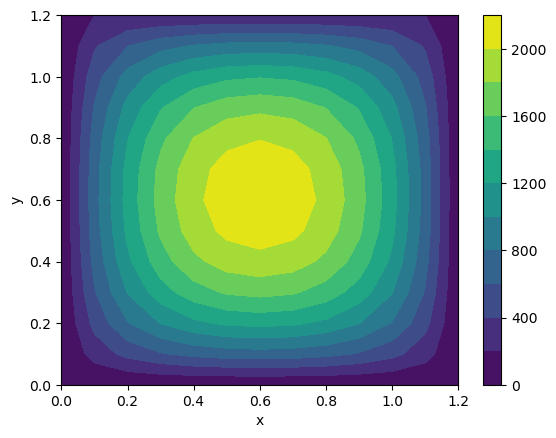

In [3]:
# plotting 
x_axis = np.linspace(0, L, N + 1)
y_axis = np.linspace(H, 0, N + 1)
X, Y = np.meshgrid(x_axis, y_axis)
plt.contourf(X, Y, d2, 10)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')